In [ ]:
# Enable autoreload of local Python modules (e.g., models)
# %load_ext autoreload
# %autoreload 2

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import jax
import jax.numpy as jnp
import optax
import time
import itertools
import matplotlib.pyplot as plt

# local imports
import models as models
import generation as generation


In [5]:
# initialize the jax random key
key = jax.random.key(0)

# Load data

In [6]:
# load the ./data/text8_train.txt and ./data/text8_test.txt files
with open("./text8_train.txt", "r") as f:
    train_text = f.read()
with open("./text8_test.txt", "r") as f:
    test_text = f.read()

# print the length of the training text and test text
print(f"Length of training text: {len(train_text):_} characters")
print(f"Length of test text: {len(test_text):_} characters")

Length of training text: 90_000_000 characters
Length of test text: 5_000_000 characters


In [7]:
# Build vocabulary (lowercase + space + a few punctuations)
char_set = list("abcdefghijklmnopqrstuvwxyz ")
char_to_int = {ch:i for i,ch in enumerate(char_set)}
int_to_char = {i:ch for ch,i in char_to_int.items()}

def encode(s):
    """Encode string to array of integers"""
    ids = [char_to_int[c] for c in s]
    return np.array(ids, dtype=np.uint8)  # use np.uint8 to save space

vocab_size=len(char_set)

# Create a basic Transformer model

In [8]:
def create_train_state(rng, vocab_size=27, d_model=64, n_layers=6, n_heads=8, max_len=128):
    # create a basic Transformer model
    model = models.DecoderOnlyTransformer(vocab_size, d_model, n_layers, n_heads, max_len)
    # create a dummy input for initialization
    dummy = jnp.zeros((1, min(16, max_len)), dtype=jnp.int32)
    # pass the dummy input to the model to initialize the parameters
    params = model.init({"params": rng}, dummy)["params"]
    return model, params

In [9]:
# compute the number of parameters
def count_params(params):
    return sum(x.size for x in jax.tree_util.tree_leaves(params))

In [10]:
# # sanity check: create a batch of data & run a forward pass
# B, T = 4, 32
# batch = jax.random.randint(
#     key=key,
#     shape=(B, T), minval=0, maxval=len(char_set))
# logits = model.apply({"params": params}, batch)

# print("batch shape:", batch.shape)  # (B, T)
# print("logits shape:", logits.shape)  # (B, T, vocab_size)

# Loss function

In [11]:
def loss_and_metrics(logits, targets, signal="All"):
    if signal == "Last":
        return loss_and_metrics_last(logits, targets)
    elif signal == "Weighted":
        return loss_and_metrics_weighted(logits, targets)
    else:
        return loss_and_metrics_all(logits, targets)

@jax.jit
def loss_and_metrics_all(logits, targets):
    """Compute cross-entropy loss and accuracy.

    Args:
      logits: (B, T, V)
      targets: (B, T)
      signal: "All" | "Last" | "Weighted"
    """
    vocab = logits.shape[-1]
    B, T = targets.shape

    # Flatten for optax loss, then reshape back
    flat_logits = logits.reshape(-1, vocab)
    flat_targets = targets.reshape(-1)
    per_pos = optax.softmax_cross_entropy_with_integer_labels(flat_logits, flat_targets)
    per_pos = per_pos.reshape(B, T)
    loss = per_pos.mean()

    # Predictions
    preds = jnp.argmax(logits, axis=-1)
    is_match = preds == targets

    # Metrics
    acc_all = jnp.mean(is_match.astype(jnp.float32))
    acc_last = jnp.mean(is_match[:, -1].astype(jnp.float32))

    metrics = {"loss": loss, "acc": acc_all, "acc_last": acc_last}
    return loss, metrics

@jax.jit
def loss_and_metrics_weighted(logits, targets):
    """Compute cross-entropy loss and accuracy.

    Args:
      logits: (B, T, V)
      targets: (B, T)
      signal: "All" | "Last" | "Weighted"
    """
    vocab = logits.shape[-1]
    B, T = targets.shape

    # Flatten for optax loss, then reshape back
    flat_logits = logits.reshape(-1, vocab)
    flat_targets = targets.reshape(-1)
    per_pos = optax.softmax_cross_entropy_with_integer_labels(flat_logits, flat_targets)
    per_pos = per_pos.reshape(B, T)
    positions = jnp.arange(T)
    weights = (positions + 1) / T
    loss = (per_pos * weights).mean()

    # Predictions
    preds = jnp.argmax(logits, axis=-1)
    is_match = preds == targets

    # Metrics
    acc_all = jnp.mean(is_match.astype(jnp.float32))
    acc_last = jnp.mean(is_match[:, -1].astype(jnp.float32))

    metrics = {"loss": loss, "acc": acc_all, "acc_last": acc_last}
    return loss, metrics

@jax.jit
def loss_and_metrics_last(logits, targets):
    """Compute cross-entropy loss and accuracy.

    Args:
      logits: (B, T, V)
      targets: (B, T)
      signal: "All" | "Last" | "Weighted"
    """
    vocab = logits.shape[-1]
    B, T = targets.shape

    # Flatten for optax loss, then reshape back
    flat_logits = logits.reshape(-1, vocab)
    flat_targets = targets.reshape(-1)
    per_pos = optax.softmax_cross_entropy_with_integer_labels(flat_logits, flat_targets)
    per_pos = per_pos.reshape(B, T)
    loss = per_pos[:, -1].mean()

    # Predictions
    preds = jnp.argmax(logits, axis=-1)
    is_match = preds == targets

    # Metrics
    acc_all = jnp.mean(is_match.astype(jnp.float32))
    acc_last = jnp.mean(is_match[:, -1].astype(jnp.float32))

    metrics = {"loss": loss, "acc": acc_all, "acc_last": acc_last}
    return loss, metrics


# Optimization step:

In [12]:
# create an update function
def train_step(model, params, opt_state, x, y, tx, loss_signal="All"):
    """Single optimization step using optax optimizer.

    Args:
    model: nn.Module object (Modified from original)
      params: pytree of model parameters.
      opt_state: optax optimizer state corresponding to `params`.
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
      tx: optax.GradientTransformation (already initialized).
      loss_signal: strategy for calculating loss. Possible values = "Last", "Weighted", "All"

    Returns:
      new_params: updated parameters after one gradient step.
      new_opt_state: updated optimizer state.
      metrics: dict of scalar metrics (loss, acc).
    """
    def loss_fn(params):
        logits = model.apply({"params": params}, x)
        loss, metrics = loss_and_metrics(logits, y, loss_signal)
        return loss, metrics

    # compute gradients (loss is scalar, metrics is auxiliary)
    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # optax update: compute parameter updates and new optimizer state
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics

# jit: last argument should be static because it is an object
train_step = jax.jit(train_step, static_argnames=("model", "tx", "loss_signal",))

# Batch creation:

In [13]:
# create a batch from the training data
def get_batch(text_int, B, T):
    """Create a random batch of data from text_int.

    Args:
      text_int: 1D array of token ids.
      B: batch size (number of sequences).
      T: sequence length (number of tokens per sequence).

    Returns:
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
    """
    # choose random starting indices for each sequence in the batch
    ix = np.random.randint(0, len(text_int) - T, size=B)
    # inputs are text from i to i+T
    x = np.stack([text_int[i:i+T] for i in ix])
    # targets are text from i+1 to i+T+1
    y = np.stack([text_int[i+1:i+T+1] for i in ix])
    return jnp.array(x, dtype=jnp.int32), jnp.array(y, dtype=jnp.int32)

# Run experiment:

In [14]:
def run_experiment(T, d_model, n_layers, n_heads, loss_signal, learning_rate, key=key, niter=10000):
    B = 128
    max_len = 128
    model, params = create_train_state(key, vocab_size, d_model, n_layers, n_heads, max_len)
    # print(f"Number of parameters: {count_params(params):_}")
    train_text_int = encode(train_text)
    test_text_int = encode(test_text)
    tx = optax.adam(learning_rate=learning_rate)
    # print(f"Initialized optimizer: Adam lr={learning_rate}")
    opt_state = tx.init(params)
    loss_history = []
    time_history = []
    time_test_history = []
    loss_test_history = []
    time_start = time.time()
    for it in range(niter):
        batch = get_batch(train_text_int, B, T)
        input, target = batch[0], batch[1]
        params_new, opt_state_new, metrics = train_step(model, params, opt_state, input, target, tx, loss_signal)

        # update params and opt_state
        params = params_new
        opt_state = opt_state_new
        acc = metrics['acc']
        acc_last = metrics['acc_last']
        loss = metrics['loss']

        loss_history.append(loss)
        time_history.append(time.time() - time_start)

        if (it % 50 == 0 & it != 0) or it == niter - 1:
            time_since_start = time.time() - time_start
            # compute loss on test set
            B_test, T_test = 1024, T
            test_batch = get_batch(test_text_int, B_test, T_test)
            test_input, test_target = test_batch[0], test_batch[1]
            test_logits = model.apply({"params": params}, test_input)
            test_loss, test_metrics = loss_and_metrics(test_logits, test_target)
            test_acc = test_metrics['acc']
            test_acc_last = test_metrics['acc_last']
            loss_test_history.append(test_loss)
            time_test_history.append(time_since_start)
            print(f"iteration {it:_}  time: {time_since_start:.1f} seconds")
            print(f"\t \t loss(train :: test): {loss:.4f} :: {test_loss:.4f}")
            print(f"\t \t accuracy (train :: test): {100*acc:.1f}% :: {100*test_acc:.1f}%")
            print(f"\t \t accuracy (last character) (train :: test): {100*acc_last:.1f}% :: {100*test_acc_last:.1f}%")
            print()

    return {
        'loss_history': loss_history,
        'time_history': time_history,
        'time_test_history': time_test_history,
        'loss_test_history': loss_test_history
    }

def plot_loss(time_history, loss_history, time_test_history, loss_test_history):
    plt.plot(time_history, loss_history, '-', label='train', color="blue")
    plt.plot(time_test_history, loss_test_history, '-', label='test', lw=2, color="red")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Loss")
    plt.legend(loc='upper right')
    plt.title("Training Loss History")
    plt.grid()

In [15]:
# Check for variability in hyperparameter tuning
# from skopt import gp_minimize
# from skopt.space import Categorical, Real, Integer
# from skopt.utils import use_named_args

# for _ in range(10):
#     key, subkey = jax.random.split(key)
#     search_space = [
#         Integer(8, 32, name="T"),
#         Integer(64, 256, name="d_model"),
#         Integer(1, 8, name='n_layers'),
#         Integer(1, 8, name='n_heads'),
#         Categorical(["All", "Last", "Weighted"], name="loss_signal"),
#         Real(1e-4, 1e-1, name='learning_rate', prior='log-uniform'),
#     ]

#     @use_named_args(search_space)
#     def objective(**config):
#         if config["d_model"] % config["n_heads"] != 0:
#             return float(1e9)
#         config['key'] = subkey
#         config['niter'] = 50
#         result = run_experiment(**config)
#         return float(result["loss_test_history"][-1])  # minimize final val loss

#     res = gp_minimize(objective, search_space, n_calls=30, random_state=0)

#     print("✅ Best parameters:")
#     for name, val in zip([s.name for s in search_space], res.x):
#         print(f"  {name}: {val}")

#     print(f"Lowest validation loss: {res.fun:.4f}")

# # Convergence reached
# T: 32
# d_model: 152
# n_layers: 4
# n_heads 8
# loss_signal: "Weighted"
# learning_rate: 1e-4

In [16]:
# config = {
#     "T": 32,
#     "d_model": 152,
#     "n_layers": 4,
#     "n_heads": 8,
#     "learning_rate": 1e-4
# }
# for loss in ["All", "Weighted", "Last"]:
#   config['loss_signal'] = loss
#   res = run_experiment(**config)

In [17]:
def run_experiment_scheduler(T, d_model, n_layers, n_heads, loss_signal, learning_rate, key=key, niter=10000):
    B = 128
    max_len = 128
    model, params = create_train_state(key, vocab_size, d_model, n_layers, n_heads, max_len)
    train_text_int = encode(train_text)
    test_text_int = encode(test_text)

    warmup_steps = int(0.05 * niter)
    warmup_fn = optax.linear_schedule(
        init_value=0.0,
        end_value=learning_rate,
        transition_steps=warmup_steps
    )
    cosine_fn = optax.cosine_decay_schedule(
        init_value=learning_rate,
        decay_steps=niter - warmup_steps
    )
    scheduler = optax.join_schedules(
        schedules=[warmup_fn, cosine_fn],
        boundaries=[warmup_steps]
    )
    tx = optax.adam(scheduler)
    opt_state = tx.init(params)
    loss_history = []
    time_history = []
    time_test_history = []
    loss_test_history = []
    time_start = time.time()
    for it in range(niter):
        batch = get_batch(train_text_int, B, T)
        input, target = batch[0], batch[1]
        params_new, opt_state_new, metrics = train_step(model, params, opt_state, input, target, tx, loss_signal)

        # update params and opt_state
        params = params_new
        opt_state = opt_state_new
        acc = metrics['acc']
        acc_last = metrics['acc_last']
        loss = metrics['loss']

        loss_history.append(loss)
        time_history.append(time.time() - time_start)

        if (it % 50 == 0 & it != 0) or it == niter - 1:
            time_since_start = time.time() - time_start
            # compute loss on test set
            B_test, T_test = 1024, T
            test_batch = get_batch(test_text_int, B_test, T_test)
            test_input, test_target = test_batch[0], test_batch[1]
            test_logits = model.apply({"params": params}, test_input)
            test_loss, test_metrics = loss_and_metrics(test_logits, test_target)
            test_acc = test_metrics['acc']
            test_acc_last = test_metrics['acc_last']
            loss_test_history.append(test_loss)
            time_test_history.append(time_since_start)
            print(f"iteration {it:_}  time: {time_since_start:.1f} seconds")
            print(f"\t \t loss(train :: test): {loss:.4f} :: {test_loss:.4f}")
            print(f"\t \t accuracy (train :: test): {100*acc:.1f}% :: {100*test_acc:.1f}%")
            print(f"\t \t accuracy (last character) (train :: test): {100*acc_last:.1f}% :: {100*test_acc_last:.1f}%")
            print()

    return {
        'loss_history': loss_history,
        'time_history': time_history,
        'time_test_history': time_test_history,
        'loss_test_history': loss_test_history
    }

In [18]:
# config = {
#     "T": 32,
#     "d_model": 152,
#     "n_layers": 4,
#     "n_heads": 8,
#     "learning_rate": 1e-4
# }
# for loss in ["All", "Weighted", "Last"]:
#   config['loss_signal'] = loss
#   res = run_experiment_scheduler(**config)

iteration 9_999  time: 165.6 seconds
	 	 loss(train :: test): 1.6904 :: 2.8782
	 	 accuracy (train :: test): 20.7% :: 20.1%
	 	 accuracy (last character) (train :: test): 50.0% :: 46.3%

iteration 9_999  time: 167.8 seconds
	 	 loss(train :: test): 1.7057 :: 2.7863
	 	 accuracy (train :: test): 19.5% :: 20.2%
	 	 accuracy (last character) (train :: test): 48.4% :: 47.1%



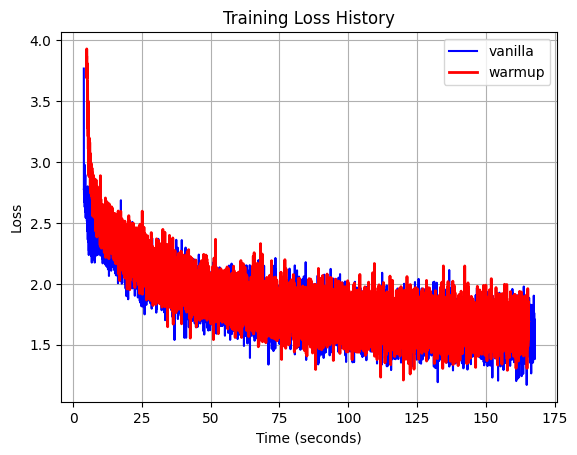

In [19]:
config = {
    "T": 32,
    "d_model": 152,
    "n_layers": 4,
    "n_heads": 8,
    "learning_rate": 1e-4,
    "loss_signal": "Last"
}
res_warmup = run_experiment_scheduler(**config)
res_vanilla = run_experiment(**config)
plt.plot(res_vanilla["time_history"], res_vanilla["loss_history"], '-', label='vanilla', color="blue")
plt.plot(res_warmup["time_history"], res_warmup["loss_history"], '-', label='warmup', lw=2, color="red")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title("Training Loss History")
plt.grid()